<a href="https://colab.research.google.com/github/VeraMendes/DS-Unit-2-Kaggle-Challenge/blob/master/module4/Vera_Mendes_Assignment_kaggle_challenge_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Kaggle Challenge, Module 4

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 60% accuracy (above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](https://towardsdatascience.com/maximizing-scarce-maintenance-resources-with-data-8f3491133050), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading
- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Simple guide to confusion matrix terminology](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/) by Kevin Markham, with video
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)
- [ ] Stacking Ensemble. (See below)

### Stacking Ensemble

Here's some code you can use to "stack" multiple submissions, which is another form of ensembling:

```python
import pandas as pd

# Filenames of your submissions you want to ensemble
files = ['submission-01.csv', 'submission-02.csv', 'submission-03.csv']

target = 'status_group'
submissions = (pd.read_csv(file)[[target]] for file in files)
ensemble = pd.concat(submissions, axis='columns')
majority_vote = ensemble.mode(axis='columns')[0]

sample_submission = pd.read_csv('sample_submission.csv')
submission = sample_submission.copy()
submission[target] = majority_vote
submission.to_csv('my-ultimate-ensemble-submission.csv', index=False)
```

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import plotly.express as px
import pandas_profiling
from sklearn.feature_selection import f_regression, SelectKBest
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from ipywidgets import interact
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import classification_report
from scipy.stats import randint, uniform
from sklearn.pipeline import Pipeline

In [0]:
# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [0]:
# date_recorded appears as object, change into datetime format
train['date_recorded'] = pd.to_datetime(train['date_recorded'],infer_datetime_format=True)
test['date_recorded'] = pd.to_datetime(test['date_recorded'],infer_datetime_format=True)  

In [0]:
# Splitting data in a time series manner and making val and test +- same size
val = train[train['date_recorded'] >= '2013-02-11']
train = train[train['date_recorded'] < '2013-02-11']

In [183]:
print(train.shape)
print(val.shape)
print(test.shape)

(44983, 41)
(14417, 41)
(14358, 40)


In [0]:
train.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group', 'status_group'],
      dtype='object')

In [0]:
import plotly.express as px
px.scatter(train, x='date_recorded', y='construction_year', color='status_group', opacity=0.1)

In [0]:
import plotly.express as px
px.scatter(train, x='region_code', y='district_code', color='status_group', opacity=0.1)

In [99]:
train.groupby('source')['status_group'].value_counts()

source                status_group           
dam                   non functional              352
                      functional                  212
                      functional needs repair      22
hand dtw              functional                  452
                      non functional              345
                      functional needs repair      17
lake                  non functional              591
                      functional                  162
                      functional needs repair      12
machine dbh           non functional             4179
                      functional                 3975
                      functional needs repair     379
other                 functional                  115
                      non functional               79
rainwater harvesting  functional                  952
                      non functional              446
                      functional needs repair     251
river                 functional    

In [0]:
train.groupby('waterpoint_type')['status_group'].value_counts()

waterpoint_type              status_group           
cattle trough                functional                    18
                             non functional                12
communal standpipe           functional                 11540
                             non functional              6070
                             functional needs repair     1656
communal standpipe multiple  non functional              2608
                             functional                  1543
                             functional needs repair      507
dam                          functional                     6
hand pump                    functional                  9403
                             non functional              5027
                             functional needs repair      885
improved spring              functional                   493
                             non functional               127
                             functional needs repair       75
other            

In [0]:
def clean(X):
  # defining one cleaning method for all my data

  # create a copy 
  X = X.copy()

  # values of latitude near zero will be treated as zero
  X['latitude'] = X['latitude'].replace(-2e-08, 0)

  # When columns have zeros and shouldn't, they are like null values.
  # So we will replace the zeros with nulls, and impute missing values later.
  cols_to_clean = ['longitude', 'latitude', 'amount_tsh','construction_year',
                   'gps_height', 'permit','public_meeting', 'region_code',
                   'district_code', 'source', 'quantity','quality_group',
                   'payment','water_quality', 'source_class','management',
                   'management_group', 'population','installer','funder',
                   'scheme_management', 'scheme_name']
  for col in cols_to_clean:
    X[col] = X[col].replace(0, np.nan)
    X[col] = X[col].replace('unknown', np.nan)

  # extract year and month of inspection
  X['month_inspection'] = X['date_recorded'].dt.month
  X['year_inspection'] = X['date_recorded'].dt.year

  # extract number of years till inspection
  X['inspection_waiting_time'] = X['year_inspection'] - X['construction_year']

  # binning numeric values
  gps_cut_points = [-63, 250, 1100, 1600, 2770]
  gps_label_names = ['-63-250', '251-1100', '1101-1600', '1601-2700']
  X['gps_height_cat'] = pd.cut(X['gps_height'], gps_cut_points, labels=gps_label_names)

  # quantity & quantity_group same as payment & payment_type are duplicates
  # drop duplicates, date_recorded, less relevance columns and columns used for binning
  X = X.drop(columns=['quantity_group','payment_type','date_recorded', 'recorded_by',
                      'gps_height','construction_year', 'scheme_name', 'num_private'])

  # return my clean function
  return X

train = clean(train)
val = clean(val)
test = clean(test) 


# defining my y vector
target = 'status_group'

# Get my train DF without the target
train_features = train.drop(columns=[target])

# list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# list of all categorical features with cardinality <= 50
categorical_features = cardinality[cardinality <= 50].index.tolist()

# Combine the lists 
features = numeric_features + categorical_features

# arranging my X features and y vector
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

In [185]:
print(train.shape)
print(val.shape)
print(test.shape)

(44983, 37)
(14417, 37)
(14358, 36)


In [101]:
pipeline = make_pipeline(
    ce.BackwardDifferenceEncoder(),
    SimpleImputer(strategy='median'),
    RandomForestClassifier(n_estimators=100,max_depth=21, random_state=42,n_jobs=-1)
)
# Fitting on train, scoring on val
pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 0.7109662204342097


In [102]:
pipeline = make_pipeline(
    ce.PolynomialEncoder(),
    SimpleImputer(strategy='median'),
    RandomForestClassifier(n_estimators=100,max_depth=21, random_state=42,n_jobs=-1)
)
# Fitting on train, scoring on val
pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 0.727197059027537


In [103]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    RandomForestClassifier(n_estimators=100,max_depth=21, random_state=42,n_jobs=-1)
)
# Fitting on train, scoring on val
pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 0.7283068599569952


In [186]:
pipeline = make_pipeline(
    ce.SumEncoder(),
    SimpleImputer(strategy='median'),
    RandomForestClassifier(n_estimators=100,max_depth=21, random_state=42,n_jobs=-1)
)
# Fitting on train, scoring on val
pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 0.7348269404175626


In [0]:
# applying to new data
y_pred = pipeline.predict(X_test)

In [0]:
submission = test[['id']].copy()
submission['status_group'] = y_pred
submission.describe()
submission.to_csv('VMsubmission.csv', index=False)

In [0]:
y_pred = pipeline.predict(X_val)

In [194]:
print(y_val.shape)
print(y_pred.shape)

(14417,)
(14417,)


In [195]:
unique_labels(y_val)

array(['functional', 'functional needs repair', 'non functional'],
      dtype='<U23')

In [196]:
def plot_confusion_matrix(y_true, y_pred):
    labels = unique_labels(y_true)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    return columns, index

plot_confusion_matrix(y_val, y_pred)

(['Predicted functional',
  'Predicted functional needs repair',
  'Predicted non functional'],
 ['Actual functional',
  'Actual functional needs repair',
  'Actual non functional'])

In [197]:
# Pandas dataframe
def plot_confusion_matrix(y_true, y_pred):
    labels = unique_labels(y_true)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_true, y_pred), 
                         columns=columns, index=index)
    return table

plot_confusion_matrix(y_val, y_pred)

,Predicted functional,Predicted functional needs repair,Predicted non functional
Actual functional,8023,46,514
Actual functional needs repair,784,79,126
Actual non functional,2331,22,2492


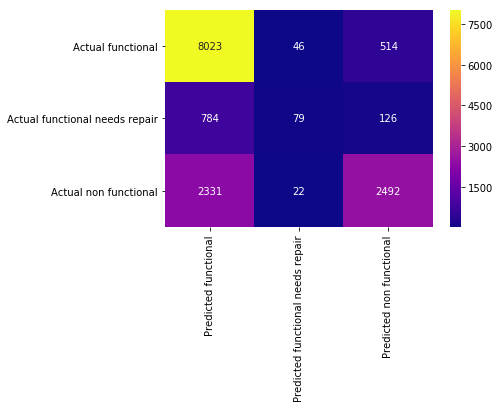

In [206]:
# Plotting a heatmap
%matplotlib inline
def plot_confusion_matrix(y_true, y_pred):
    labels = unique_labels(y_true)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_true, y_pred), 
                         columns=columns, index=index)
    return sns.heatmap(table, annot=True, fmt='d', cmap='plasma')

plot_confusion_matrix(y_val, y_pred);

In [0]:
# other method:
# analysing values before pipeline to fill nans with most adequate value 

In [135]:
train.isnull().sum()

id                             0
amount_tsh                 33119
funder                      2875
installer                   2892
longitude                   1598
latitude                    1598
wpt_name                       0
basin                          0
subvillage                   371
region                         0
region_code                    0
district_code                 23
lga                            0
ward                           0
population                 20397
public_meeting              5885
scheme_management           3496
permit                     16357
extraction_type                0
extraction_type_group          0
extraction_type_class          0
management                   408
management_group             408
payment                     5753
water_quality               1510
quality_group               1510
quantity                     640
source                        40
source_type                    0
source_class                 234
waterpoint

In [0]:
def clean(X):
  # defining one cleaning method for all my data

  # create a copy 
  X = X.copy()

  # values of latitude near zero will be treated as zero
  X['latitude'] = X['latitude'].replace(-2e-08, 0)

  # When columns have zeros and shouldn't, they are like null values.
  # So we will replace the zeros with nulls, and impute missing values later.
  cols_to_clean = ['longitude', 'latitude', 'amount_tsh','construction_year',
                   'gps_height', 'permit','public_meeting', 'region_code',
                   'district_code', 'source', 'quantity','quality_group',
                   'payment','water_quality', 'source_class','management',
                   'management_group', 'population','installer','funder',
                   'scheme_management', 'scheme_name']
  for col in cols_to_clean:
    X[col] = X[col].replace(0, np.nan)
    X[col] = X[col].replace('unknown', np.nan)

  # extract year and month of inspection
  X['month_inspection'] = X['date_recorded'].dt.month
  X['year_inspection'] = X['date_recorded'].dt.year

  # extract number of years till inspection
  X['inspection_waiting_time'] = X['year_inspection'] - X['construction_year']

  # binning numeric values
  gps_cut_points = [-63, 250, 1100, 1600, 2770]
  gps_label_names = ['-63-250', '251-1100', '1101-1600', '1601-2700']
  X['gps_height_cat'] = pd.cut(X['gps_height'], gps_cut_points, labels=gps_label_names)

  # quantity & quantity_group same as payment & payment_type are duplicates
  # drop duplicates, date_recorded, less relevance columns and columns used for binning
  X = X.drop(columns=['quantity_group','payment_type','date_recorded', 'recorded_by',
                      'gps_height','construction_year', 'scheme_name', 'num_private'])

  # return my clean function
  return X

train = clean(train)
test = clean(test) 


# defining my y vector
target = 'status_group'

# Get my train DF without the target
train_features = train.drop(columns=[target])

# list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# list of all categorical features with cardinality <= 50
categorical_features = cardinality[cardinality <= 50].index.tolist()

# Combine the lists 
features = numeric_features + categorical_features

# arranging my X features and y vector
X_train = train[features]
y_train = train[target]
X_test = test[features]

In [0]:
numeric_features = ['amount_tsh', 'longitude', 'latitude', 'population', 'district_code',
             'inspection_waiting_time']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))])

categorical_features = ['funder', 'installer', 'subvillage', 'public_meeting',
             'scheme_management', 'scheme_name', 'permit', 'management',
             'management_group', 'payment','water_quality', 'quality_group',
             'quantity', 'source', 'source_class', 'gps_height_cat']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', ce.OrdinalEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

clf = Pipeline(steps=[('preprocessor', preprocessor),
                ('classifier', RandomForestClassifier(n_estimators=100,max_depth=21, random_state=42,n_jobs=-1))]) 

In [0]:
# checking best hyperparameters with RandomizedSearchCV
param_distributions = {
    'preprocessor__num__imputer__strategy': ['median'],
    'preprocessor__cat__imputer__strategy': ['most_frequent'],
    'randomforestclassifier__n_estimators': randint(30, 300), 
    'randomforestclassifier__max_depth': [5, 10, 15, 22, None], 
    'randomforestclassifier__max_features': uniform(0, 1),

}

search = RandomizedSearchCV(
    clf, 
    param_distributions=param_distributions, 
    n_iter=10, 
    cv=3, 
    scoring='accuracy', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

search.fit(X_train, y_train);